## New visualizations 
of below vs. above peak density $\rho$ across field and embeddings

In [4]:
import pandas as pd
import plotnine as pn

import sciterra

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [5]:
from sciterra import Atlas

The figure: 
- x axis: below vs. above modal density
- y axis: mean CPY for that partition
- facet / categorical x axis: field or embedding

In [6]:
atlas_dir = "/Users/nathanielimel/uci/projects/citesim/outputs/librarian=S2/vectorizer=SciBERT/center=Imeletal2022"

atlas_dir = "/Users/nathanielimel/uci/projects/citesim/outputs/librarian=S2/vectorizer=GPT2/center=Imeletal2022"

In [7]:
csv_fn = f"{atlas_dir}/all_data.csv"
df = pd.read_csv(csv_fn)
df

,density,edginess,citations_per_year,is_center
0,34.188350,0.676286,14.700000,False
1,38.251657,0.689314,0.000000,False
2,30.065278,0.643242,1.882353,False
3,30.986188,0.661160,7.960000,False
4,35.578884,0.681289,1.000000,False
...,...,...,...,...
17854,33.075136,0.709616,2.428571,False
17855,30.821204,0.694993,0.800000,False
17856,33.248875,0.642085,0.263158,False
17857,33.802700,0.722598,0.000000,False


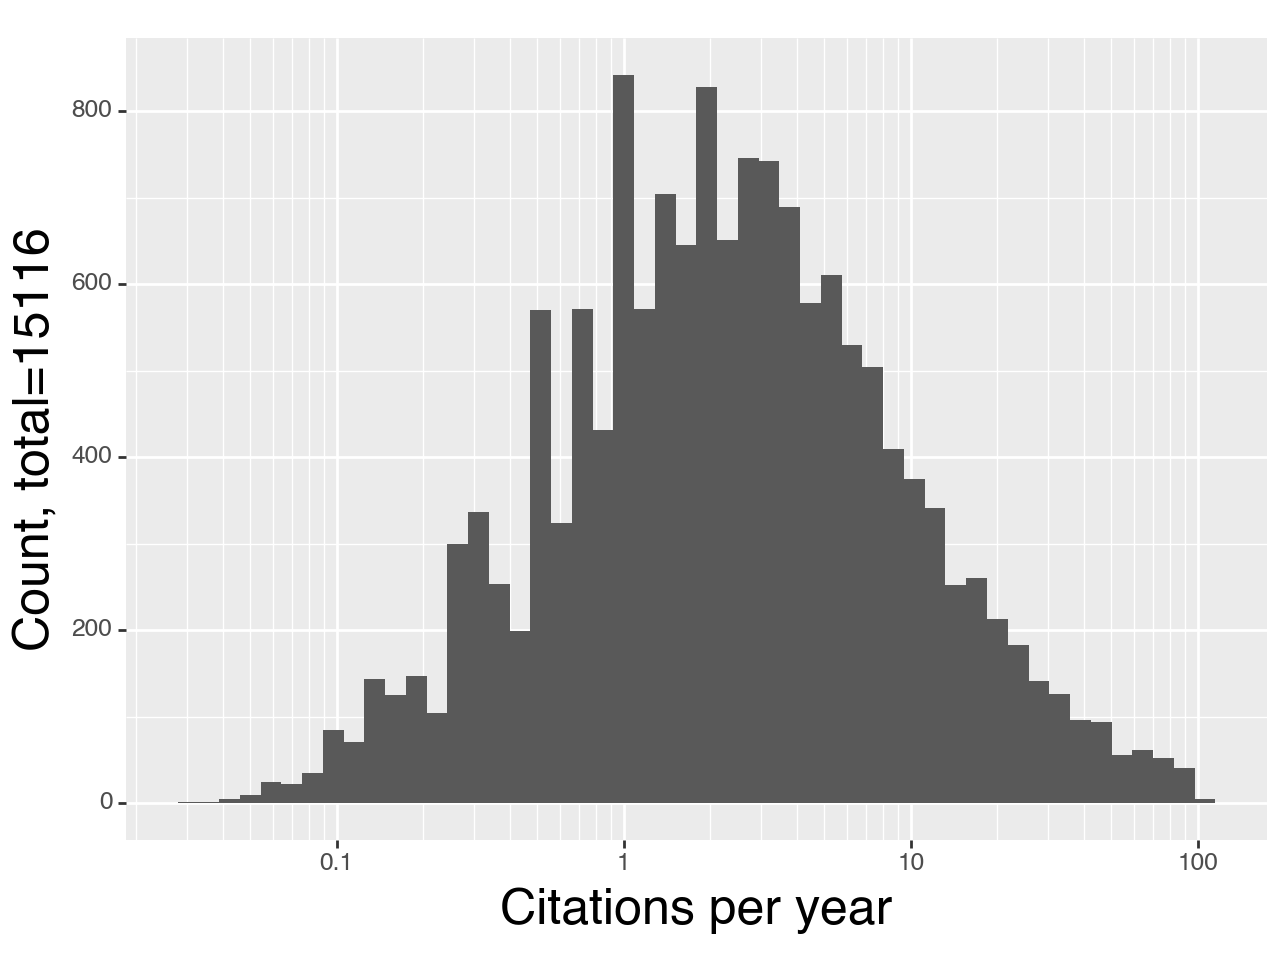

<Figure Size: (640 x 480)>

In [8]:
df_f = df[(df["citations_per_year"] > 0) & (df["citations_per_year"] <= 100.)]

(
    pn.ggplot(
        # df,
        df_f,
        mapping=pn.aes(x="citations_per_year")
    )
    + pn.geom_histogram(bins=50)
    + pn.scale_x_log10()
    + pn.xlab("Citations per year")
    + pn.ylab(f"Count, total={len(df_f)}")
    + pn.theme(
        axis_title=pn.element_text(size=18)
    )
)

In [9]:
# How many points are N cpy and below?
N = df["citations_per_year"].mean() + 1*df["citations_per_year"].std()
cpy = df["citations_per_year"]
print(f"{len(cpy[cpy <= N])}/{len(cpy)} = ({len(cpy[cpy <= N]) / len(cpy) * 100} %) of publications received <= {N} cpy")

17665/17859 = (98.91371297385072 %) of publications received <= 87.2738150581419 cpy


In [10]:
# How many points are M density and below
M = df["density"].mean() + 1*df["density"].std()
M = 60
rho = df["density"]
print(f"{len(rho[rho <= N])}/{len(rho)} = ({len(rho[rho <= M]) / len(rho) * 100} %) of publications have <= {M} density")

17805/17859 = (99.60804076376057 %) of publications have <= 60 density


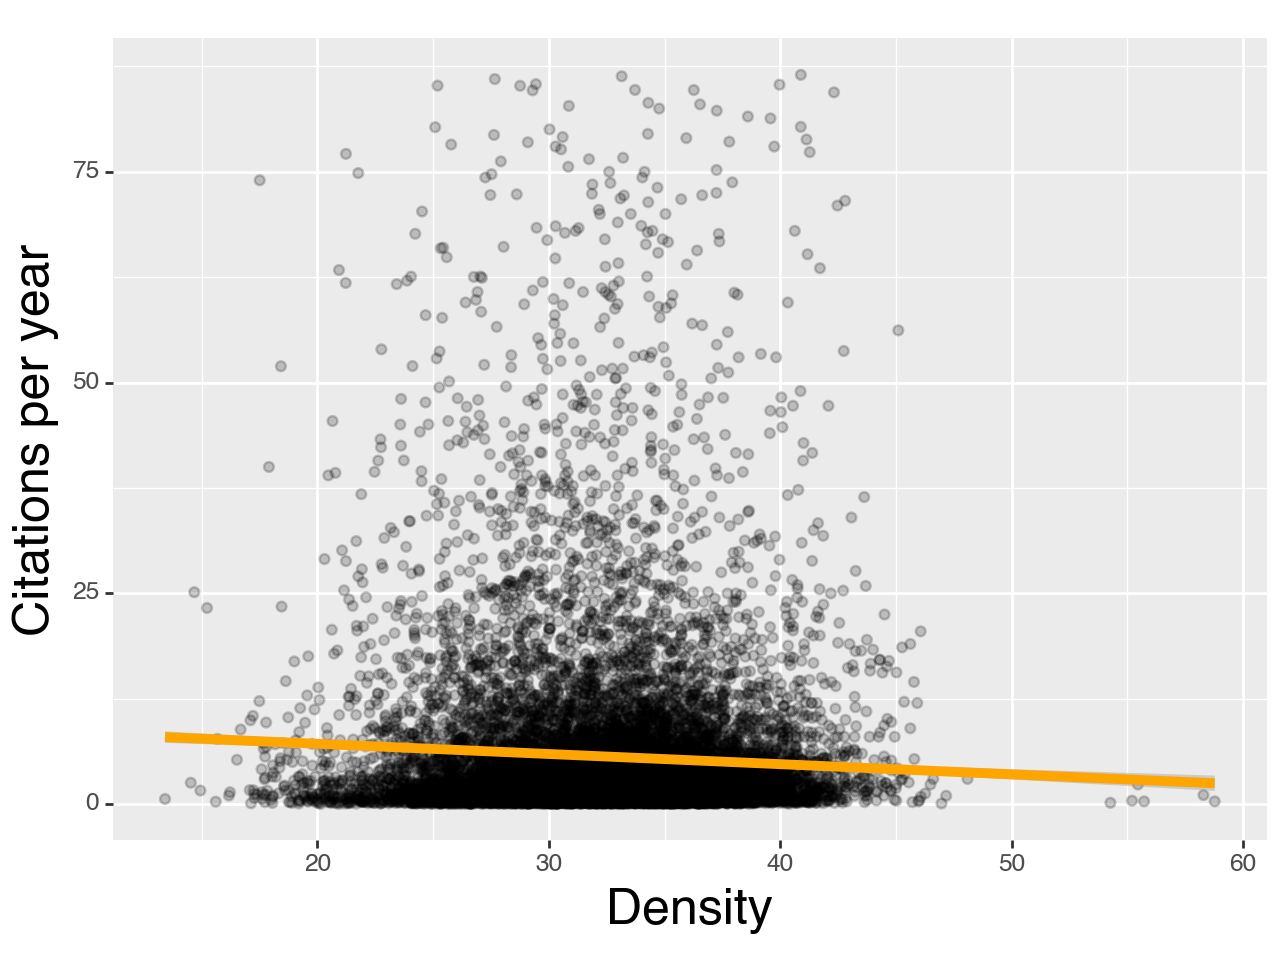

<Figure Size: (640 x 480)>

In [11]:
df_filtered = df[(df["citations_per_year"] > 0) & (df["citations_per_year"] <= N)]
df_filtered = df_filtered[df_filtered["density"] <= M]

(
    pn.ggplot(
        df_filtered,
        mapping=pn.aes(
            x="density", 
            # x="edginess",
            y="citations_per_year",
        )
    )
    + pn.geom_point(
        alpha=0.2,
    )
    + pn.xlab("Density")
    # + pn.xlab("Asymmetry")
    + pn.ylab("Citations per year")
    + pn.geom_smooth(color="orange", size=2)
    + pn.theme(
        # axis_title_y=pn.element_blank(),
        axis_title=pn.element_text(size=18),
    )
)

In [12]:
# What is the modal density value?
mode = df_filtered.density.mode().item()
mode

23.308290881349464

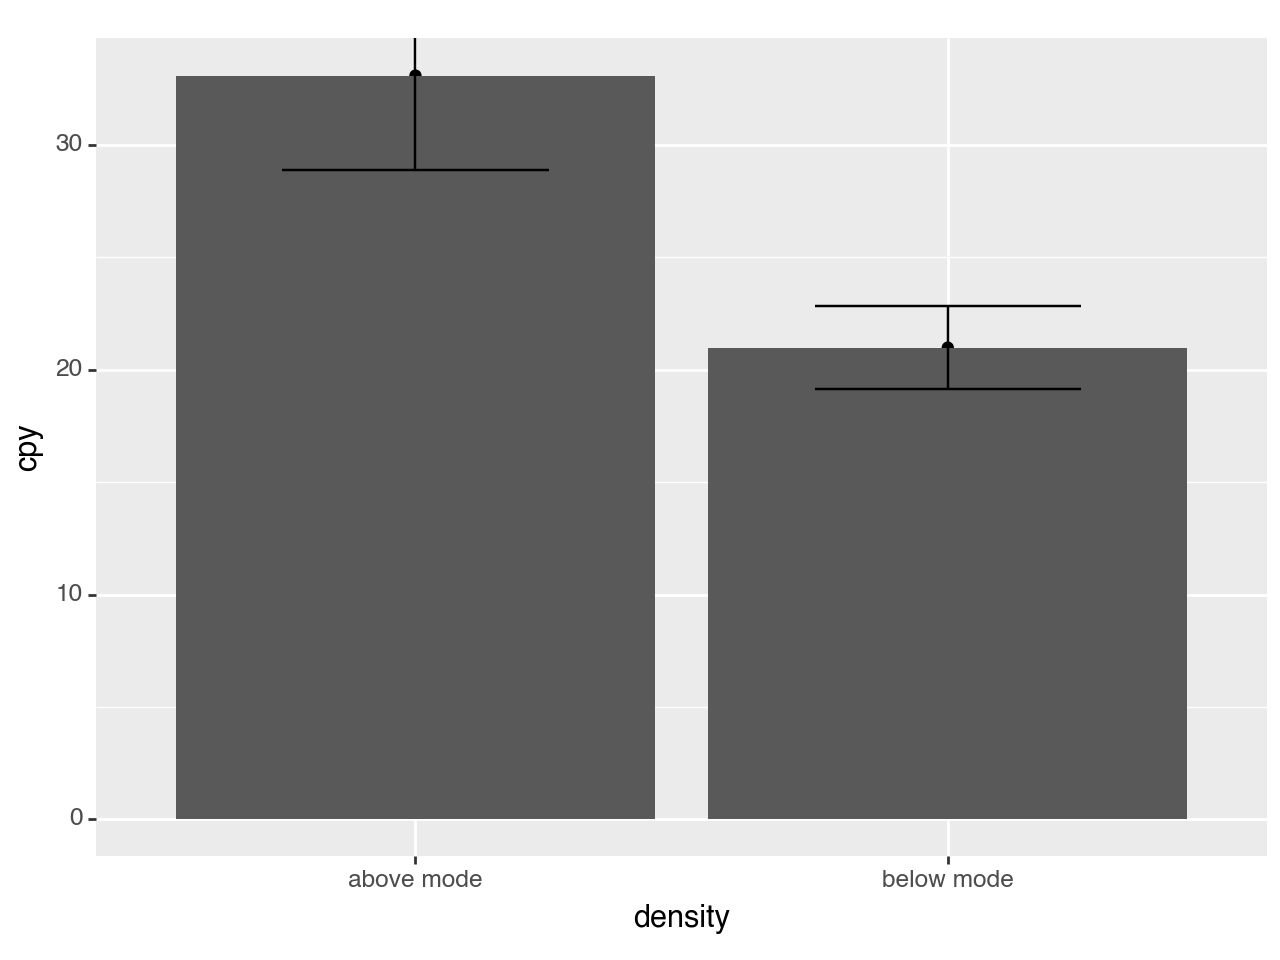

<Figure Size: (640 x 480)>

In [13]:

df_below = df_filtered[df_filtered["density"] < mode]
df_above = df_filtered[df_filtered["density"] > mode]

mean_cpy_below = df_below.density.mean().item()
std_cpy_below = df_below.density.std().item()
mean_cpy_above = df_above.density.mean().item()
std_cpy_above = df_above.density.std().item()

below_data = pd.DataFrame(
    [("below mode", mean_cpy_below)],
    #  ("above mode", mean_cpy_above)],
    columns=["density", "cpy"],
)

above_data = pd.DataFrame(
    [("above mode", mean_cpy_above)],
    columns=["density", "cpy"],
)

data = pd.concat([below_data, above_data])

# add some dummy faceting?
data["vectorizer"] = ["a"]*int(len(data)/2) + ["b"]*int(len(data)/2)

plot = (
    pn.ggplot(
        data,
        pn.aes(
            x="density",
            y="cpy",
        )
    )
    + pn.geom_point()
    + pn.geom_col(data=above_data)
    + pn.geom_errorbar(
        data=above_data,
        ymin=mean_cpy_above - std_cpy_above,
        ymax=mean_cpy_above + std_cpy_above,
    )

    + pn.geom_col(data=below_data)
    + pn.geom_errorbar(
        data=below_data,
        ymin=mean_cpy_below - std_cpy_below,
        ymax=mean_cpy_below + std_cpy_below,
    )
)
plot

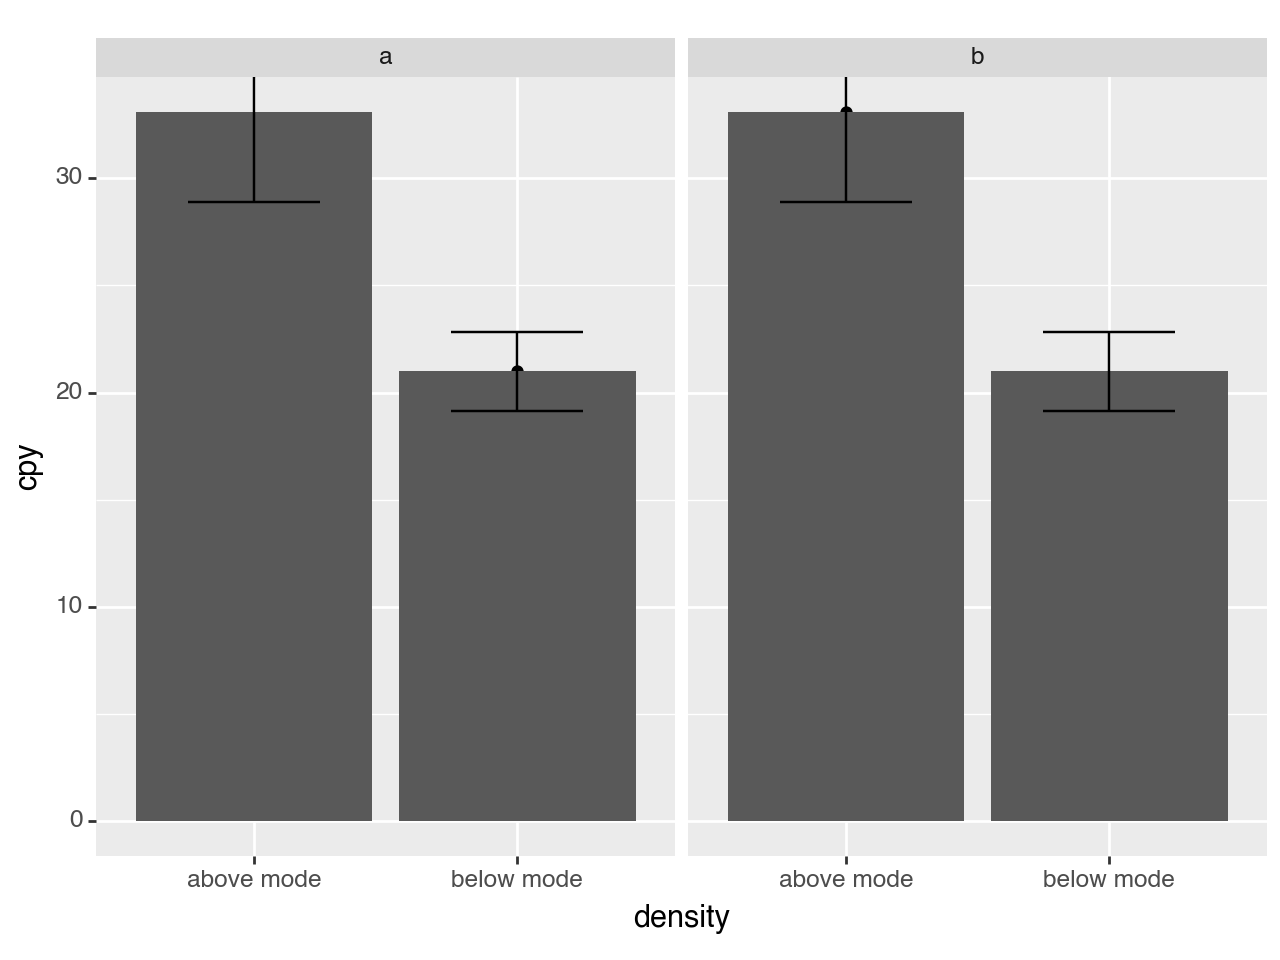

<Figure Size: (640 x 480)>

In [14]:
# dummy faceting
(
    pn.ggplot(
        data,
        pn.aes(
            x="density",
            y="cpy",
        )
    )
    + pn.facet_wrap("vectorizer")
    + pn.geom_point()
    + pn.geom_col(data=above_data)
    + pn.geom_errorbar(
        data=above_data,
        ymin=mean_cpy_above - std_cpy_above,
        ymax=mean_cpy_above + std_cpy_above,
    )

    + pn.geom_col(data=below_data)
    + pn.geom_errorbar(
        data=below_data,
        ymin=mean_cpy_below - std_cpy_below,
        ymax=mean_cpy_below + std_cpy_below,
    )
)

Okay, let's try to facet by field now.

In [38]:
def preprocess(atlas_dir: str) -> pd.DataFrame:

    # Sloppy for now
    csv_fn = f"{atlas_dir}/all_data.csv"
    df = pd.read_csv(csv_fn)
    
    # How many points are N cpy and below?
    N = df["citations_per_year"].mean() + 1*df["citations_per_year"].std()
    cpy = df["citations_per_year"]
    print(f"{len(cpy[cpy <= N])}/{len(cpy)} = ({len(cpy[cpy <= N]) / len(cpy) * 100} %) of publications received <= {N} cpy")

    # How many points are M density and below
    M = df["density"].mean() + 1*df["density"].std()
    M = 60
    rho = df["density"]
    print(f"{len(rho[rho <= N])}/{len(rho)} = ({len(rho[rho <= M]) / len(rho) * 100} %) of publications have <= {M} density")    

    df_filtered = df[(df["citations_per_year"] > 0) & (df["citations_per_year"] <= N)]
    df_filtered = df_filtered[df_filtered["density"] <= M]    

    return df_filtered


def get_plot(df_filtered: pd.DataFrame) -> pn.ggplot:
    # to facet
    mode = df_filtered.density.mode().item()
    # alias cpy
    df_filtered["cpy"] = df_filtered["citations_per_year"]
    
    df_below = df_filtered[df_filtered["density"] < mode]
    df_above = df_filtered[df_filtered["density"] > mode]

    mean_cpy_below = df_below.cpy.mean().item()
    std_cpy_below = df_below.cpy.std().item()
    mean_cpy_above = df_above.cpy.mean().item()
    std_cpy_above = df_above.cpy.std().item()

    below_data = pd.DataFrame(
        [("below mode", mean_cpy_below)],
        #  ("above mode", mean_cpy_above)],
        columns=["density", "cpy"],
    )

    above_data = pd.DataFrame(
        [("above mode", mean_cpy_above)],
        columns=["density", "cpy"],
    )

    data = pd.concat([below_data, above_data])


    plot = (
        pn.ggplot(
            data,
            pn.aes(
                x="density",
                y="cpy",
            )
        )
        + pn.geom_point()
        + pn.geom_col(data=above_data)
        + pn.geom_errorbar(
            data=above_data,
            ymin=mean_cpy_above - std_cpy_above,
            ymax=mean_cpy_above + std_cpy_above,
        )

        + pn.geom_col(data=below_data)
        + pn.geom_errorbar(
            data=below_data,
            ymin=mean_cpy_below - std_cpy_below,
            ymax=mean_cpy_below + std_cpy_below,
        )
    )
    return plot

14095/14595 = (96.57416923603974 %) of publications received <= 22.56685812574304 cpy
227/14595 = (100.0 %) of publications have <= 60 density
17665/17859 = (98.91371297385072 %) of publications received <= 87.2738150581419 cpy
17805/17859 = (99.60804076376057 %) of publications have <= 60 density


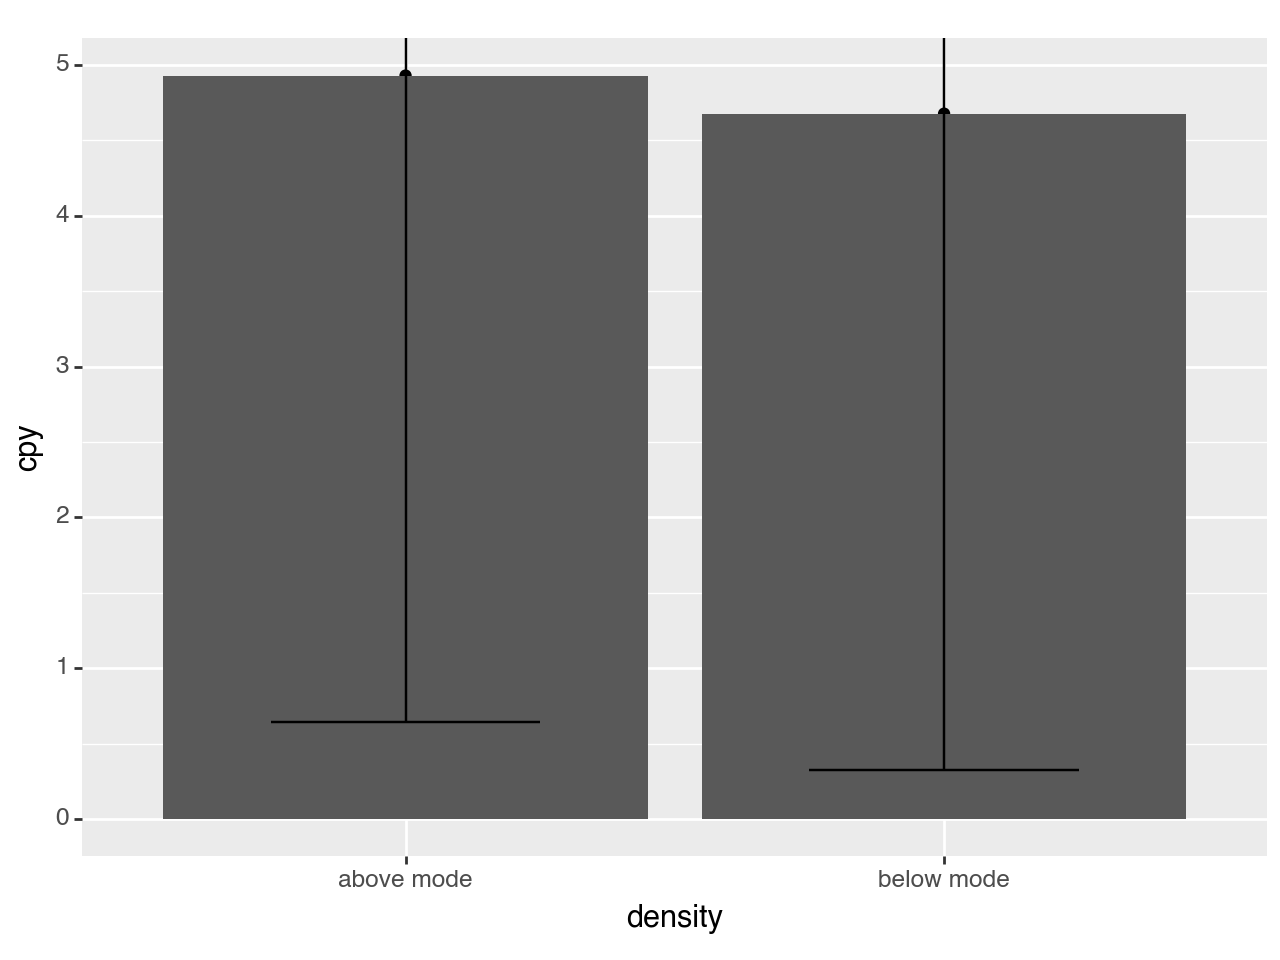

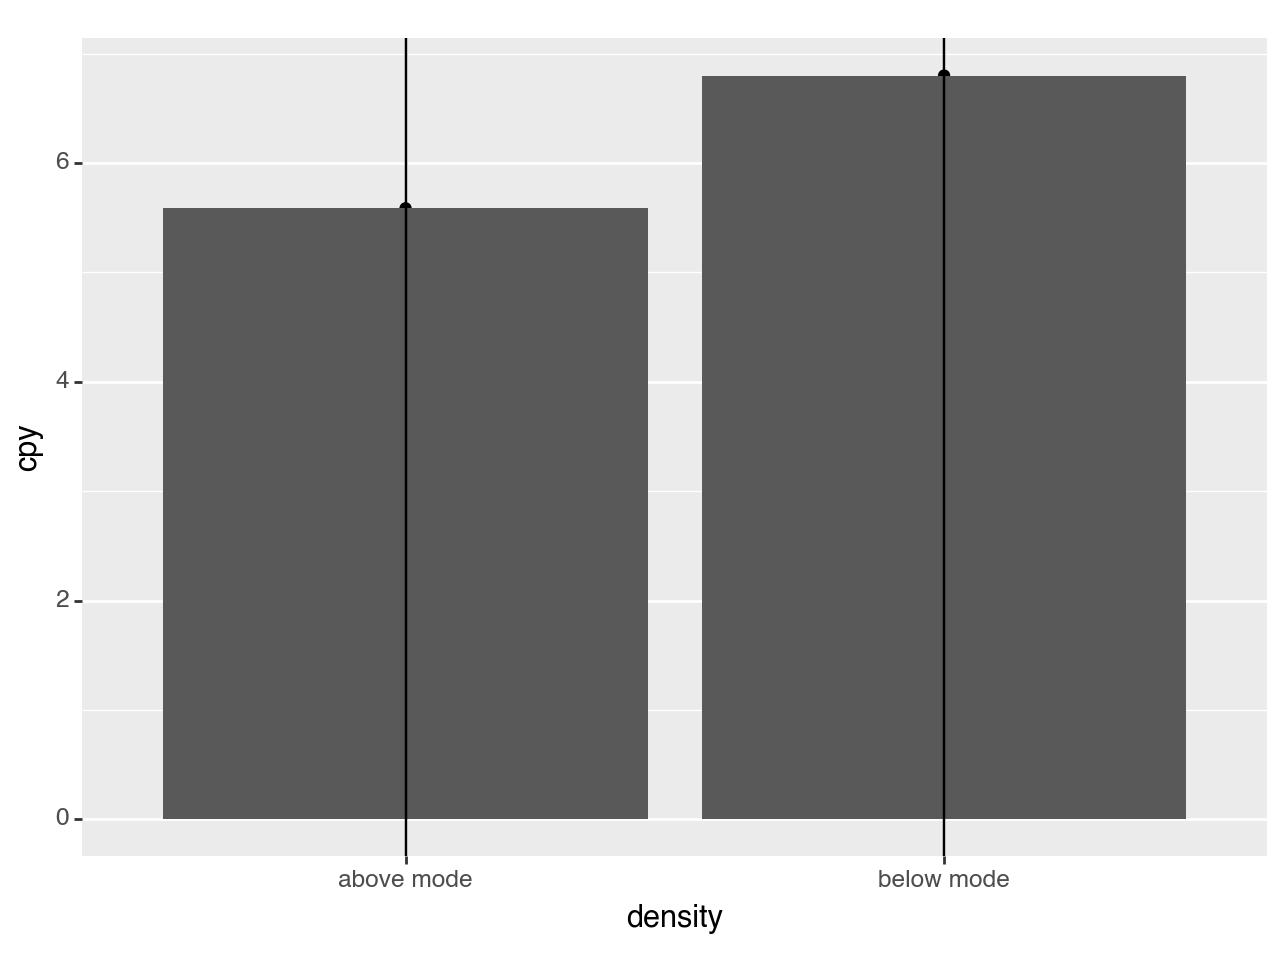

[<Figure Size: (640 x 480)>, <Figure Size: (640 x 480)>]

In [39]:
[
    get_plot(preprocess(ad)) for ad in [
        "/Users/nathanielimel/uci/projects/citesim/outputs/librarian=S2/vectorizer=SciBERT/center=hafenLowredshiftLymanLimit2017",
        "/Users/nathanielimel/uci/projects/citesim/outputs/librarian=S2/vectorizer=SciBERT/center=Imeletal2022",]
]

In [40]:
# Put into one dataframe, add discriminating column, and facet
ad1 = "/Users/nathanielimel/uci/projects/citesim/outputs/librarian=S2/vectorizer=SciBERT/center=hafenLowredshiftLymanLimit2017"
ad2 = "/Users/nathanielimel/uci/projects/citesim/outputs/librarian=S2/vectorizer=SciBERT/center=Imeletal2022"

df1 = preprocess(ad1)
df2 = preprocess(ad2)
df1["field"] = "physics"
df2["field"] = "linguistics"
df = pd.concat([df1, df2])

14095/14595 = (96.57416923603974 %) of publications received <= 22.56685812574304 cpy
227/14595 = (100.0 %) of publications have <= 60 density
17665/17859 = (98.91371297385072 %) of publications received <= 87.2738150581419 cpy
17805/17859 = (99.60804076376057 %) of publications have <= 60 density


In [91]:
from collections import namedtuple

atlas_dirs = {
    "physics": "/Users/nathanielimel/uci/projects/citesim/outputs/librarian=S2/vectorizer=SciBERT/center=hafenLowredshiftLymanLimit2017",
    "linguistics": "/Users/nathanielimel/uci/projects/citesim/outputs/librarian=S2/vectorizer=SciBERT/center=Imeletal2022",
    "medicine": "/Users/nathanielimel/uci/projects/citesim/outputs/librarian=S2/vectorizer=SciBERT/center=Torres2013",
    "education": "/Users/nathanielimel/uci/projects/citesim/outputs/librarian=S2/vectorizer=SciBERT/center=Ololube2012",
}


PlotData = namedtuple(
    "PlotData",
    field_names=[
        "plot",
        "data",
        "below_data",
        "above_data",
        "mean_cpy_above",
        "std_cpy_above",
        "mean_cpy_below",
        "std_cpy_below",
    ],
)
import numpy as np

def get_plot_data(field: str = None, dir: str = None, vectorizer: str = None):
    # Takes in a field and spits out an object containing the necessary dataframes.
    # The idea is that we pass each field and preprocess it one at a time, then combine everything after, and then plot and then facet.

    if field is not None:
        atlas_dir = atlas_dirs[field]
    if dir is not None:
        atlas_dir = dir

    # Sloppy for now
    csv_fn = f"{atlas_dir}/all_data.csv"
    df = pd.read_csv(csv_fn)
    
    # How many points are N cpy and below?
    N = df["citations_per_year"].mean() + 1*df["citations_per_year"].std()
    cpy = df["citations_per_year"]
    print(f"{len(cpy[cpy <= N])}/{len(cpy)} = ({len(cpy[cpy <= N]) / len(cpy) * 100} %) of publications received <= {N} cpy")

    # How many points are M density and below
    M = df["density"].mean() + 1*df["density"].std()
    M = 60
    rho = df["density"]
    print(f"{len(rho[rho <= N])}/{len(rho)} = ({len(rho[rho <= M]) / len(rho) * 100} %) of publications have <= {M} density")    

    df_filtered = df[(df["citations_per_year"] > 0) & (df["citations_per_year"] <= N)]
    df_filtered = df_filtered[df_filtered["density"] <= M]    

    # Annotate w field
    df_filtered["field"] = field

    mode = df_filtered.density.mode().item() # not unique
    # mode = df_filtered.density.mode()
    # mode = df_filtered.density.median() # this is horrible, but at least unique
    print("mode density: ", mode)
    # print("median density ", mode)

    # alias cpy
    df_filtered["cpy"] = df_filtered["citations_per_year"]

    
    df_below = df_filtered[df_filtered["density"] < mode]
    df_above = df_filtered[df_filtered["density"] > mode]

    # mean_cpy_below = np.nanmean(df_below.cpy)
    mean_cpy_below = df_below.cpy.mean()
    # std_cpy_below = np.nanstd(df_below.cpy)
    std_cpy_below = df_below.cpy.std()
    # mean_cpy_above = np.nanmean(df_above.cpy)
    mean_cpy_above = df_above.cpy.mean()
    # std_cpy_above = np.nanstd(df_above.cpy)
    std_cpy_above = df_above.cpy.std()

    print("the mean and std data:")
    print(mean_cpy_below, std_cpy_below, mean_cpy_above, std_cpy_above)
    print(df_below)

    # don't forget to add field
    below_data = pd.DataFrame(
        [("below mode", mean_cpy_below, field)],
        columns=["density", "cpy", "field"],
    )

    above_data = pd.DataFrame(
        [("above mode", mean_cpy_above, field)],
        columns=["density", "cpy", "field"],
    )

    data = pd.concat([below_data, above_data])

    # annotate with vectorizer
    data["vectorizer"] = vectorizer

    plot = (
        pn.ggplot(
            data,
            pn.aes(
                x="density",
                y="cpy",
            )
        )
        + pn.geom_point()

        + pn.geom_col(data=above_data)
        + pn.geom_errorbar(
            data=above_data,
            ymin=mean_cpy_above - std_cpy_above,
            ymax=mean_cpy_above + std_cpy_above,
        )

        + pn.geom_col(data=below_data)
        + pn.geom_errorbar(
            data=below_data,
            ymin=mean_cpy_below - std_cpy_below,
            ymax=mean_cpy_below + std_cpy_below,
        )
    )        

    return PlotData(
        plot,
        data,
        below_data,
        above_data,
        mean_cpy_above,
        std_cpy_above,
        mean_cpy_below,
        std_cpy_below,
    )

18079/18543 = (97.49770802998437 %) of publications received <= 39.97360269015964 cpy
17884/18543 = (99.54160599687214 %) of publications have <= 60 density
mode density:  21.511373117011782


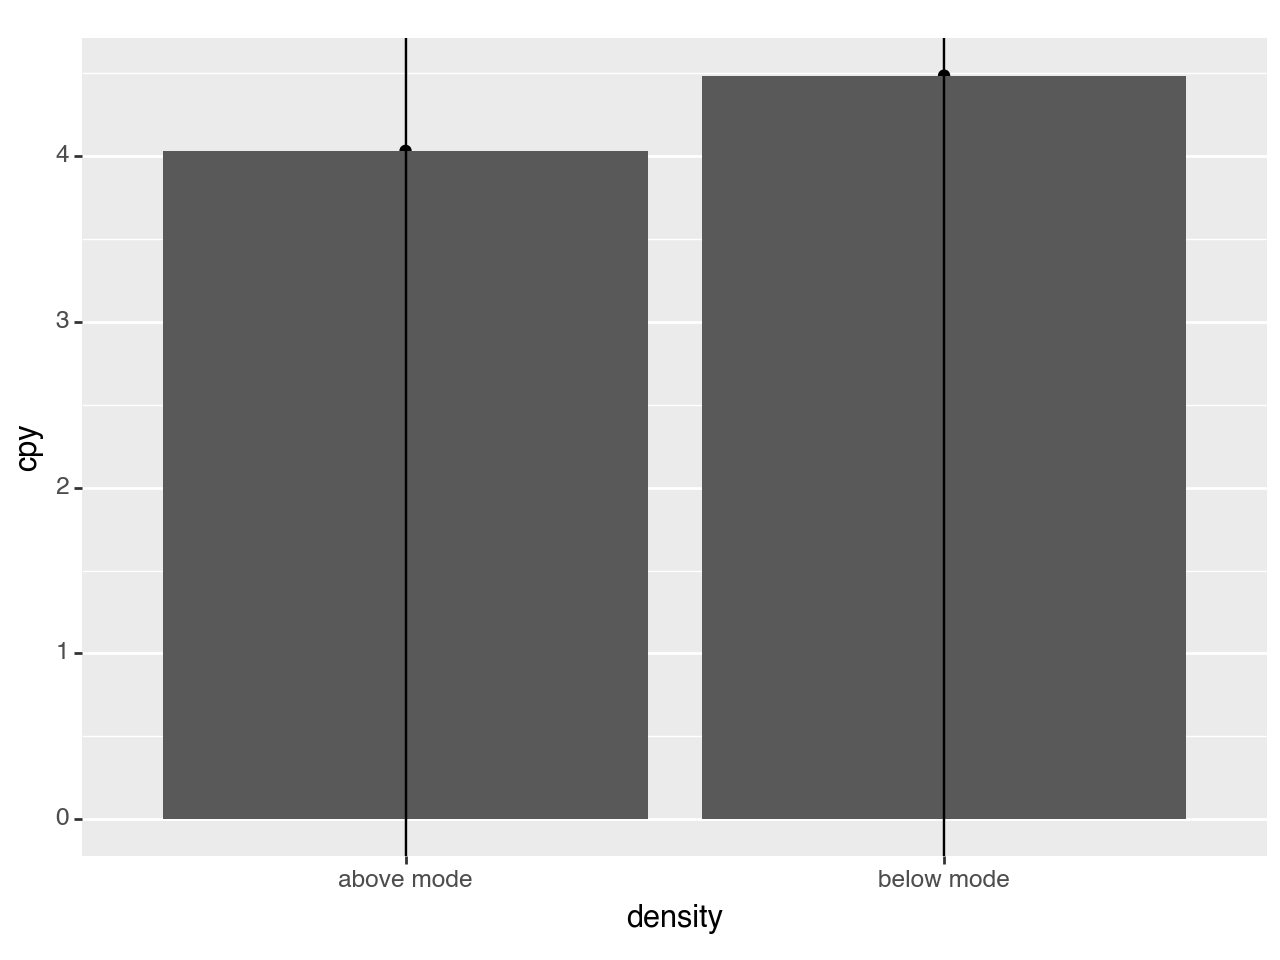

PlotData(plot=<Figure Size: (640 x 480)>, data=      density       cpy      field vectorizer
0  below mode  4.487156  education       None
0  above mode  4.033036  education       None, below_data=      density       cpy      field
0  below mode  4.487156  education, above_data=      density       cpy      field
0  above mode  4.033036  education, mean_cpy_above=4.033035725693593, std_cpy_above=6.106707674843271, mean_cpy_below=4.487156385586103, std_cpy_below=7.722726345758563)

In [65]:
get_plot_data("education")

In [102]:
# Now get each dataframe separately for field
tuples = [get_plot_data(field) for field in [
    "physics",
    "linguistics",
    "education",
    "medicine",
    ]]

14095/14595 = (96.57416923603974 %) of publications received <= 22.56685812574304 cpy
227/14595 = (100.0 %) of publications have <= 60 density
median density  39.16992841415357
the mean and std data:
4.6131085298070085 4.4584240661021095 4.814382689687758 4.214819358593196
         density  edginess  citations_per_year  is_center    field        cpy
7      38.964491  0.718031            9.000000      False  physics   9.000000
8      29.774922  0.752079            8.370370      False  physics   8.370370
10     38.215821  0.712839            0.888889      False  physics   0.888889
14     28.598264  0.746312            4.480000      False  physics   4.480000
15     37.433852  0.723678           18.250000      False  physics  18.250000
...          ...       ...                 ...        ...      ...        ...
14588  24.824157  0.715322            0.166667      False  physics   0.166667
14589  37.205336  0.672084            1.466667      False  physics   1.466667
14591  36.824599  0.7363

In [103]:
# Now plot and facet
dfs = []
plots = pn.ggplot()
for plotdata in tuples:
    dfs.append(plotdata.data)

all_data = pd.concat(dfs)

17665/17859 = (98.91371297385072 %) of publications received <= 87.2738150581419 cpy
17805/17859 = (99.60804076376057 %) of publications have <= 60 density
median density  33.106617433046075
the mean and std data:
6.2416236554647675 10.619486706873184 5.004198823346953 9.128760557311843
         density  edginess  citations_per_year  is_center        field  \
2      30.065278  0.643242            1.882353      False  linguistics   
3      30.986188  0.661160            7.960000      False  linguistics   
6      30.741669  0.715212            7.560000      False  linguistics   
8      28.353686  0.709317            0.333333      False  linguistics   
12     31.271241  0.673602            1.200000      False  linguistics   
...          ...       ...                 ...        ...          ...   
17850  31.232524  0.710645            7.000000      False  linguistics   
17851  23.498550  0.722327            4.857143      False  linguistics   
17853  32.163374  0.701783            2.307692

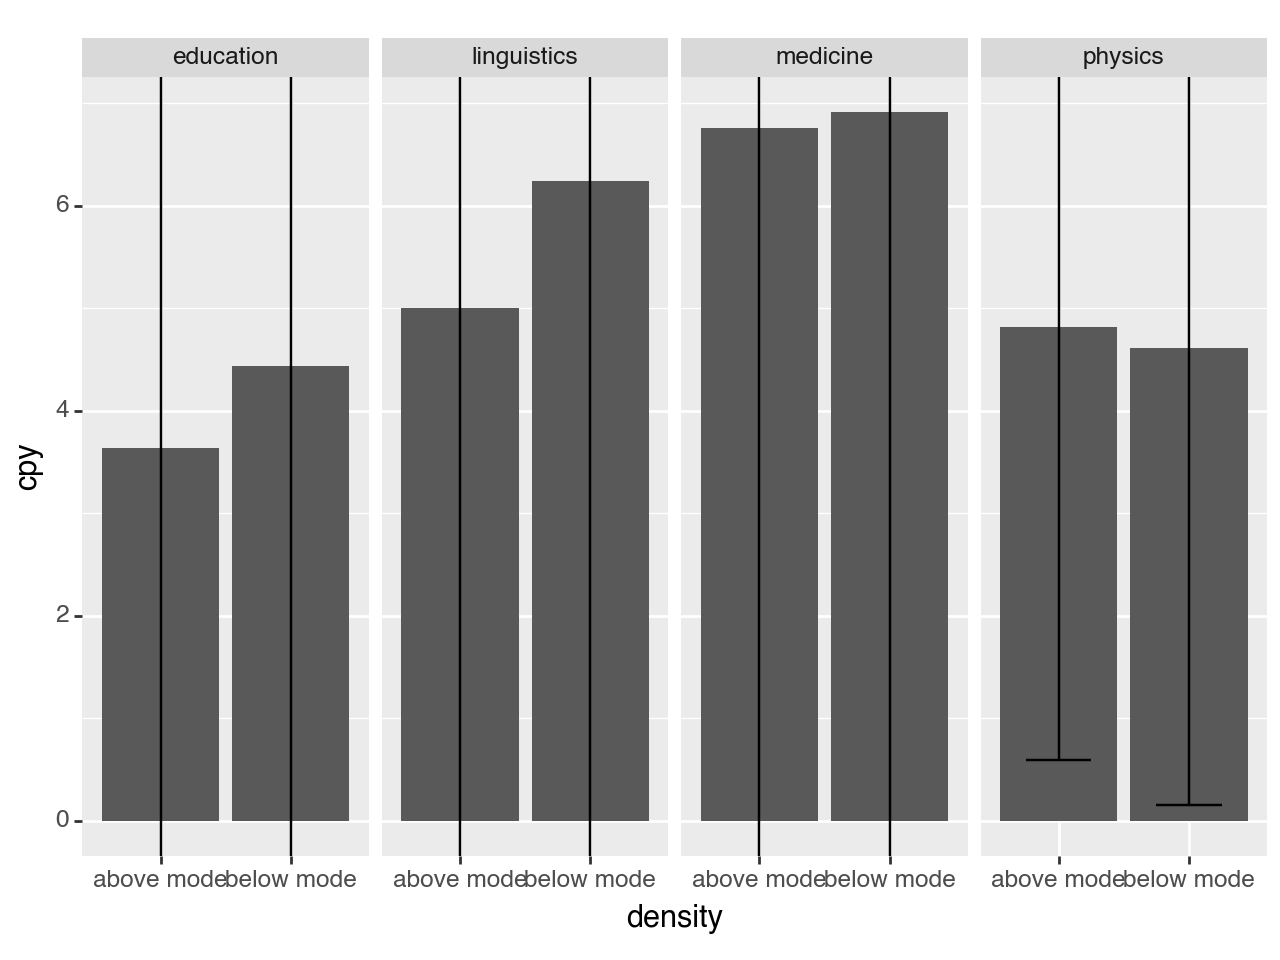

<Figure Size: (640 x 480)>

In [104]:
physics_plotdata = get_plot_data("linguistics")
linguistics_plotdata = get_plot_data("physics")
education_plotdata = get_plot_data("education")
medicine_plotdata = get_plot_data("medicine")

plot = (
    # All this work and I can't refactor, fuck plotnine
    pn.ggplot(all_data, pn.aes(x="density", y="cpy",))
    + pn.facet_grid(". ~ field")

    # Physics
    + pn.geom_col(
        data=physics_plotdata.above_data, 
    )
    + pn.geom_errorbar(
        data=physics_plotdata.above_data,
        ymin=physics_plotdata.mean_cpy_above - physics_plotdata.std_cpy_above,
        ymax=physics_plotdata.mean_cpy_above + physics_plotdata.std_cpy_above,
    )

    + pn.geom_col(
        data=physics_plotdata.below_data,
    )
    + pn.geom_errorbar(
        data=physics_plotdata.below_data,
        ymin=physics_plotdata.mean_cpy_below - physics_plotdata.std_cpy_below,
        ymax=physics_plotdata.mean_cpy_below + physics_plotdata.std_cpy_below,
    )     

    # Linguistics
    + pn.geom_col(
        data=linguistics_plotdata.above_data,
    )
    + pn.geom_errorbar(
        data=linguistics_plotdata.above_data,
        ymin=linguistics_plotdata.mean_cpy_above - linguistics_plotdata.std_cpy_above,
        ymax=linguistics_plotdata.mean_cpy_above + linguistics_plotdata.std_cpy_above,
    )

    + pn.geom_col(
        data=linguistics_plotdata.below_data,
    )
    + pn.geom_errorbar(
        data=linguistics_plotdata.below_data,
        ymin=linguistics_plotdata.mean_cpy_below - linguistics_plotdata.std_cpy_below,
        ymax=linguistics_plotdata.mean_cpy_below + linguistics_plotdata.std_cpy_below,
    )

    # Education
    + pn.geom_col(
        data=education_plotdata.above_data,
    )
    + pn.geom_errorbar(
        data=education_plotdata.above_data,
        ymin=education_plotdata.mean_cpy_above - education_plotdata.std_cpy_above,
        ymax=education_plotdata.mean_cpy_above + education_plotdata.std_cpy_above,
    )

    + pn.geom_col(
        data=education_plotdata.below_data,
    )
    + pn.geom_errorbar(
        data=education_plotdata.below_data,
        ymin=education_plotdata.mean_cpy_below - education_plotdata.std_cpy_below,
        ymax=education_plotdata.mean_cpy_below + education_plotdata.std_cpy_below,
    )

    # Medicine
    + pn.geom_col(
        data=medicine_plotdata.above_data,
    )
    + pn.geom_errorbar(
        data=medicine_plotdata.above_data,
        ymin=medicine_plotdata.mean_cpy_above - medicine_plotdata.std_cpy_above,
        ymax=medicine_plotdata.mean_cpy_above + medicine_plotdata.std_cpy_above,
    )

    + pn.geom_col(
        data=medicine_plotdata.below_data,
    )
    + pn.geom_errorbar(
        data=medicine_plotdata.below_data,
        ymin=medicine_plotdata.mean_cpy_below - medicine_plotdata.std_cpy_below,
        ymax=medicine_plotdata.mean_cpy_below + medicine_plotdata.std_cpy_below,
    )

)
plot

In [70]:
# save
plot.save("modes-cpy-fields.png", width=10, height=6, dpi=300)

Saving 10 x 6 in image.
Filename: modes-cpy-fields.png


## Now: across vectorizers instead of across fields

To do this, we'll probably want to aggregate fields. But for now, let's just zoom in on Physics. Since we're only comparing summary statistics anyway (above vs. below mode), we don't need to worry about normalizing.

In [105]:
# scibert data
scibert_dir = "/Users/nathanielimel/uci/projects/citesim/outputs/librarian=S2/vectorizer=SciBERT/center=hafenLowredshiftLymanLimit2017"

# gpt2 data
gpt2_dir = "/Users/nathanielimel/uci/projects/citesim/outputs/librarian=S2/vectorizer=GPT2/center=hafenLowredshiftLymanLimit2017"

In [93]:
all_data

,density,cpy,field,vectorizer
0,below mode,4.613109,None,scibert
0,above mode,4.814383,None,scibert
0,below mode,6.200779,None,gpt2
0,above mode,4.984967,None,gpt2


14095/14595 = (96.57416923603974 %) of publications received <= 22.56685812574304 cpy
227/14595 = (100.0 %) of publications have <= 60 density
median density  39.16992841415357
the mean and std data:
4.6131085298070085 4.4584240661021095 4.814382689687758 4.214819358593196
         density  edginess  citations_per_year  is_center field        cpy
7      38.964491  0.718031            9.000000      False  None   9.000000
8      29.774922  0.752079            8.370370      False  None   8.370370
10     38.215821  0.712839            0.888889      False  None   0.888889
14     28.598264  0.746312            4.480000      False  None   4.480000
15     37.433852  0.723678           18.250000      False  None  18.250000
...          ...       ...                 ...        ...   ...        ...
14588  24.824157  0.715322            0.166667      False  None   0.166667
14589  37.205336  0.672084            1.466667      False  None   1.466667
14591  36.824599  0.736382            0.307692     

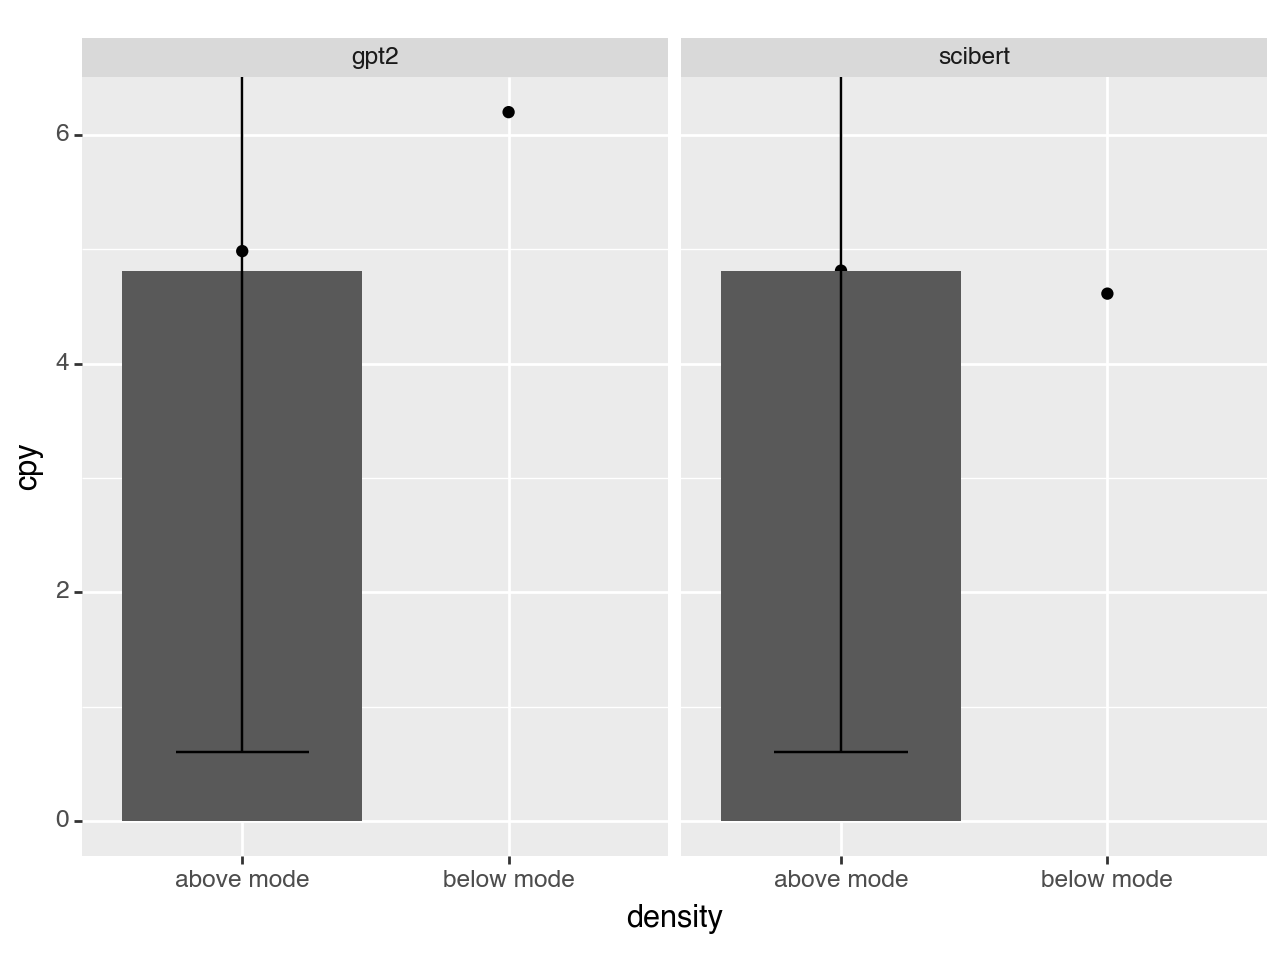

<Figure Size: (640 x 480)>

In [110]:
scibert_plotdata = get_plot_data(dir = scibert_dir, vectorizer = "scibert")
gpt2_plotdata = get_plot_data(dir = gpt2_dir, vectorizer = "gpt2")

dfs = []
plots = pn.ggplot()
for plotdata in [scibert_plotdata, gpt2_plotdata]:
    dfs.append(plotdata.data)

all_data = pd.concat(dfs)


plot = (

    pn.ggplot(all_data, pn.aes(x="density", y="cpy",))
    + pn.facet_grid(". ~ vectorizer")

    + pn.geom_point() # idk why I didn't have to do this before

    # Physics
    + pn.geom_col(
        data=scibert_plotdata.above_data, 
    )
    + pn.geom_errorbar(
        data=scibert_plotdata.above_data,
        ymin=scibert_plotdata.mean_cpy_above - scibert_plotdata.std_cpy_above,
        ymax=scibert_plotdata.mean_cpy_above + scibert_plotdata.std_cpy_above,
    )

    # + pn.geom_col(
    #     data=scibert_plotdata.below_data,
    # )
    # + pn.geom_errorbar(
    #     data=scibert_plotdata.below_data,
    #     ymin=scibert_plotdata.mean_cpy_below - scibert_plotdata.std_cpy_below,
    #     ymax=scibert_plotdata.mean_cpy_below + scibert_plotdata.std_cpy_below,
    # )     

    # # Linguistics
    # + pn.geom_col(
    #     data=gpt2_plotdata.above_data,
    # )
    # + pn.geom_errorbar(
    #     data=gpt2_plotdata.above_data,
    #     ymin=gpt2_plotdata.mean_cpy_above - gpt2_plotdata.std_cpy_above,
    #     ymax=gpt2_plotdata.mean_cpy_above + gpt2_plotdata.std_cpy_above,
    # )

    # + pn.geom_col(
    #     data=gpt2_plotdata.below_data,
    # )
    # + pn.geom_errorbar(
    #     data=gpt2_plotdata.below_data,
    #     ymin=gpt2_plotdata.mean_cpy_below - gpt2_plotdata.std_cpy_below,
    #     ymax=gpt2_plotdata.mean_cpy_below + gpt2_plotdata.std_cpy_below,
    # )
)
plot